# Data exploration M2

 ## Tools

In [2]:
# pip install pandas==1.0.5

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud
print('pandas version: ' + pd.__version__)

pandas version: 1.0.5


In [4]:
path_data = '/content/drive/MyDrive/Quotebank/'

In [5]:
# loop through nb_chunks_to_read chunks (if 0, through all chunks) and apply process_function to each of them
# return the result as a dataframe
def loop_chuncks(chunks, process_function, nb_chunks_to_read=0):
  i = 0
  result = []
  columns = None
  for chunk in chunks:
    processed = process_function(chunk)
    if processed is not None:
      if not isinstance(processed, pd.Series):
        columns = processed.columns
      for r in processed.values.tolist():
        result.append(r)
    i += 1
    if i == nb_chunks_to_read:
      break
  return pd.DataFrame(result, columns=columns)

In [24]:
# return the first 3 elements of a chunk
def chunck_head(chunk):
  return chunk.head(3)

chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
loop_chuncks(chunks, chunck_head, 1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E


## Global warming in the 2020 dataset

In [23]:
# return the quotes containing 'global warming'
def contains_global_warming(chunk):
  return chunk[chunk.quotation.str.contains('global warming')]

chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
global_warming_quotes = loop_chuncks(chunks, contains_global_warming, 10)
global_warming_quotes.sample(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
10,2020-02-20-031871,I will argue all day long with anybody who tel...,Laura Friedman,[Q6498920],2020-02-20 21:09:33,4,"[[Laura Friedman, 0.6238], [None, 0.3542], [Je...",[https://www.dailybreeze.com/2020/02/20/busine...,E


In [25]:
# to create automatically a list of synonyms
# https://towardsdatascience.com/synonyms-and-antonyms-in-python-a865a5e14ce8
nltk.download('wordnet')

words = []
for syn in wordnet.synsets("warming"):
    for lm in syn.lemmas():
             words.append(lm.name())
words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['heating',
 'warming',
 'thaw',
 'thawing',
 'warming',
 'warm',
 'warm_up',
 'warm',
 'warming',
 'calefacient',
 'warming']

In [40]:
# or do it manually
words = ['global warming', 'climate change']

In [41]:
# return the quotes containing one of the words the list
def contains_word_in_list(chunk):
  return chunk[chunk.quotation.str.contains('|'.join(words))]

chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
word_in_list_quotes = loop_chuncks(chunks, contains_word_in_list, 100)

word_in_list_quotes.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
977,2020-02-11-011709,"But everyday people may be able to say, I used...",None,[],2020-02-11 13:01:00,1,"[[None, 0.8739], [Scott Morrison, 0.1261]]",[http://www.afr.com/politics/federal/how-polit...,E
932,2020-01-29-023382,Given the election year and congressional focu...,Brian Jennings,"[Q15713604, Q4964205, Q4964207]",2020-01-29 20:20:07,2,"[[Brian Jennings, 0.8212], [None, 0.1788]]",[https://kticradio.com/agricultural/ace-announ...,E
1270,2020-02-04-114953,Why wasn't the issue of climate change there i...,Adam Aron,"[Q18205237, Q23891258]",2020-02-04 08:03:46,1,"[[Adam Aron, 0.7432], [None, 0.2568]]",[http://dailybruin.com/2020/02/04/board-of-reg...,E


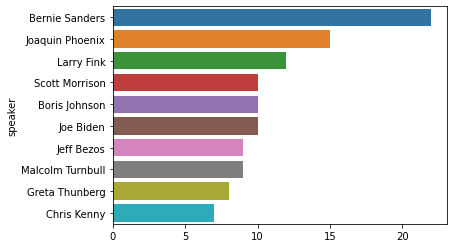

In [161]:
# the top 10 speakers using these words
top_speakers_topic_2020 = word_in_list_quotes.groupby(by='speaker').count().sort_values(by='quotation', ascending=False).quotation.iloc[1:21]
sns.barplot(x=top_speakers_topic_2020[0:10].values, y=top_speakers_topic_2020[0:10].index)

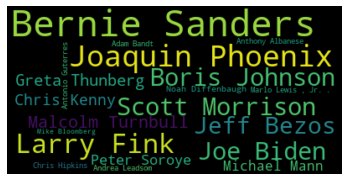

In [162]:
# word cloud for illustration
wordcloud = WordCloud().fit_words(dict(top_speakers_topic_2020))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [188]:
# to return the quotations of the top 15 speakers that talk the most about the topic
top_speakers_list = list(top_speakers_topic_2020.index)
def top_topic_speakers(chunk):
  return chunk.query("speaker == @top_speakers_list")
top_topic_speakers_quotes = loop_chuncks(chunks, top_topic_speakers, 100)

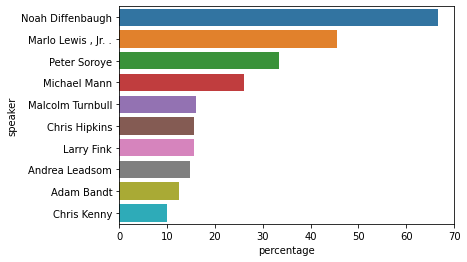

In [189]:
# to see their percentage of quotation about the topic
top_topic_speakers_quotes_count = top_topic_speakers_quotes.groupby(by='speaker').count().sort_values(by='quotation', ascending=False).quotation
speakers_topic_2020_df = pd.DataFrame({'speaker': speakers_topic_2020.index, 'quotes_topic': speakers_topic_2020.values})
top_topic_speakers_quotes_count_df = pd.DataFrame({'speaker': top_topic_speakers_quotes_count.index, 'quotes_total': top_topic_speakers_quotes_count.values})
speakers_topic_2020_quotations = speakers_topic_2020_df.merge(top_topic_speakers_quotes_count_df)
speakers_topic_2020_quotations['percentage'] = (speakers_topic_2020_quotations['quotes_topic'] / speakers_topic_2020_quotations['quotes_total']) * 100
speakers_topic_2020_quotations = speakers_topic_2020_quotations.sort_values(by='percentage', ascending=False)
sns.barplot(x='percentage', y='speaker', data=speakers_topic_2020_quotations[0:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


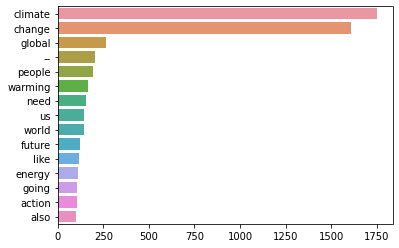

In [76]:
# words being most used in these quotes about a topic
nltk.download('stopwords')

topic_words = collections.Counter()
stop_words = set(stopwords.words('english'))
for index, row in word_in_list_quotes.iterrows():
    for word in row.quotation.lower().replace(',', '').replace('.', '').split():
        if word not in stop_words:
            topic_words[word] += 1
top_topic_words = topic_words.most_common()[:50]
sns.barplot(x=[x[1] for x in top_topic_words][:15], y=[x[0] for x in top_topic_words][:15])

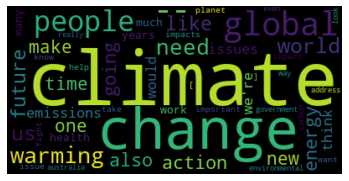

In [77]:
# word cloud for illustration
wordcloud = WordCloud().fit_words(dict(top_topic_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Global warming in all the datasets

In [19]:
# number of quotations containing a topic through time
years = ['2015', '2016', '2017', '2018', '2019', '2020']
count_years = []
number_chunks = 10
for year in years:
  chunks = pd.read_json(path_data + 'quotes-' + year + '.json.bz2', lines=True, compression='bz2', chunksize=10000)
  count = loop_chuncks(chunks, contains_word_in_list, number_chunks).size
  count_years.append(count)
count_years

[1170, 828, 1008, 819, 1530, 1476]

Text(0.5, 1.0, 'Quotations about global warming though time')

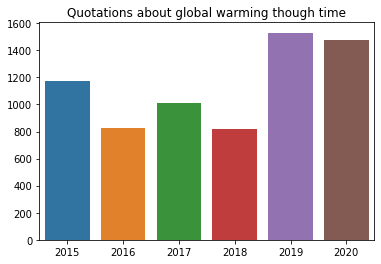

In [20]:
sns.barplot(x=years, y=count_years)
plt.title("Quotations about global warming though time")